### Setiment Analysis of Financial News Headlines Using GRU:

In [334]:
# Importing Necessary Libraries:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [335]:
# Load data
file_path = "C:\\Users\\Mohd Kaif\\Downloads\\financial_sentiment_data.csv"
data = pd.read_csv(file_path)

In [337]:
# Data Looks like:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [338]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [339]:
data.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [340]:
print(data.shape)

(5842, 2)


In [341]:
# Checking for Missing Value:
print(data.isnull().sum())

Sentence     0
Sentiment    0
dtype: int64


In [325]:
# Preprocess data
stop_words = set(stopwords.words("english"))
data['Sentence'] = data['Sentence'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x.lower()))
data['Sentence'] = data['Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [326]:
# Tokenize data
max_features = 1000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Sentence'].values)
x = pad_sequences(tokenizer.texts_to_sequences(data['Sentence'].values))

In [342]:
# Model parameters
embed_dim = 32
gru_out = 64
# Create Bidirectional GRU model
model = Sequential([
    Embedding(max_features, embed_dim, input_length=x.shape[1]),
    SpatialDropout1D(0.5),
    Bidirectional(GRU(gru_out, dropout=0.5, recurrent_dropout=0.5)),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [343]:
# Data split
Y = pd.get_dummies(data['Sentiment']).values
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)

**Building Model using GRU**

In [344]:
# Train model
epochs = 100
batch_size = 64
validation_split = 0.1
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
                    validation_split=validation_split, callbacks=[early_stopping])

Epoch 1/100
66/66 [==============================] - 8s 56ms/step - loss: 0.9875 - accuracy: 0.5363 - val_loss: 1.0186 - val_accuracy: 0.4829
Epoch 2/100
66/66 [==============================] - 3s 43ms/step - loss: 0.9204 - accuracy: 0.5686 - val_loss: 0.9160 - val_accuracy: 0.5449
Epoch 3/100
66/66 [==============================] - 3s 43ms/step - loss: 0.8403 - accuracy: 0.6293 - val_loss: 0.8794 - val_accuracy: 0.6090
Epoch 4/100
66/66 [==============================] - 3s 46ms/step - loss: 0.7845 - accuracy: 0.6595 - val_loss: 0.8614 - val_accuracy: 0.6175
Epoch 5/100
66/66 [==============================] - 3s 46ms/step - loss: 0.7455 - accuracy: 0.6844 - val_loss: 0.8196 - val_accuracy: 0.6325
Epoch 6/100
66/66 [==============================] - 3s 49ms/step - loss: 0.6934 - accuracy: 0.7075 - val_loss: 0.8222 - val_accuracy: 0.6368
Epoch 7/100
66/66 [==============================] - 3s 49ms/step - loss: 0.6683 - accuracy: 0.7203 - val_loss: 0.8140 - val_accuracy: 0.6496
Epoch 

In [345]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2, batch_size=batch_size)
print(f"Loss on test data: {test_loss}")
print(f"Accuracy on test data: {test_accuracy}")

19/19 - 0s - loss: 0.7124 - accuracy: 0.6903 - 320ms/epoch - 17ms/step
Loss on test data: 0.7124339938163757
Accuracy on test data: 0.6903336048126221


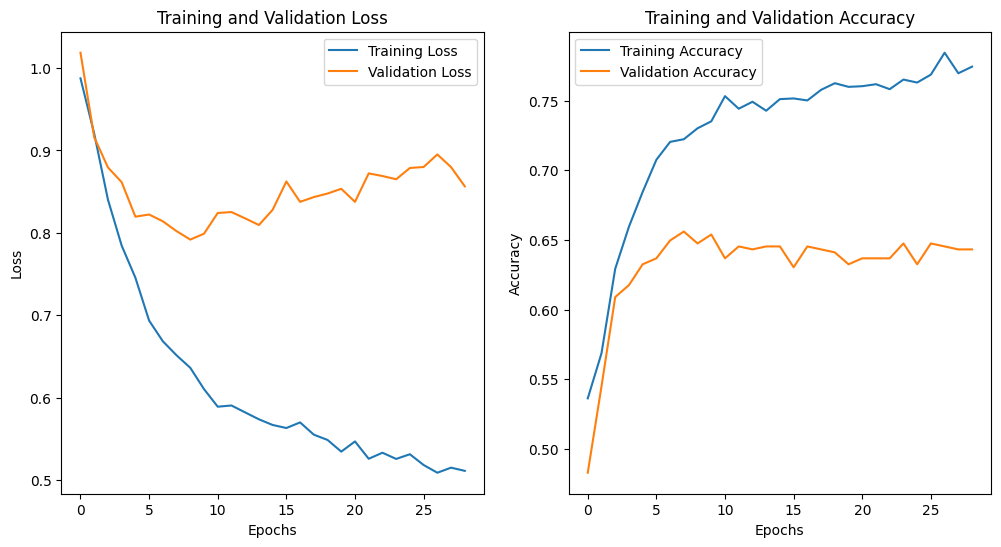

In [346]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

37/37 [==============================] - 1s 16ms/step


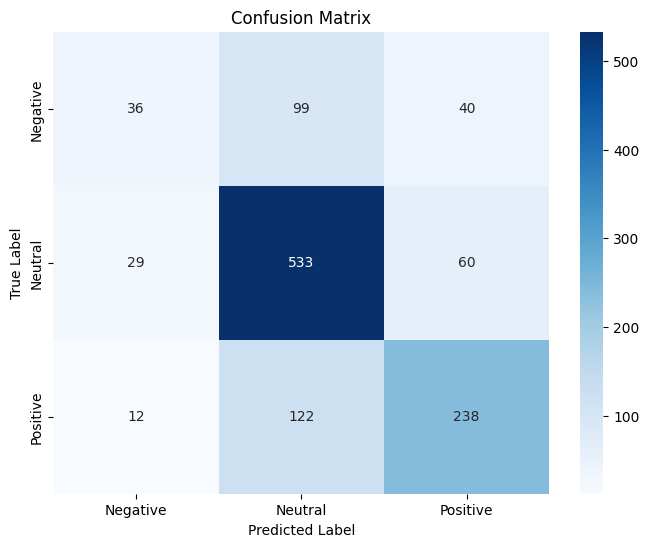

Classification Report:
              precision    recall  f1-score   support

    Negative       0.47      0.21      0.29       175
     Neutral       0.71      0.86      0.77       622
    Positive       0.70      0.64      0.67       372

    accuracy                           0.69      1169
   macro avg       0.63      0.57      0.58      1169
weighted avg       0.67      0.69      0.67      1169



In [349]:
# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
target_names = ['Negative', 'Neutral', 'Positive']
class_report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(class_report)

1/1 [==============================] - 0s 54ms/step
Sentence: The company's new product launch exceeded expectations, leading to a surge in stock prices.
Predicted Sentiment: Neutral

Sentence: Despite positive earnings, market uncertainty is causing fluctuations in stock values.
Predicted Sentiment: Positive

Sentence: Analysts are divided on the future of the tech industry, with some predicting growth and others anticipating a downturn.
Predicted Sentiment: Positive

Sentence: The economic outlook remains uncertain, with concerns about inflation and unemployment rates.
Predicted Sentiment: Neutral

Sentence: A strategic alliance with a major competitor has boosted investor confidence and contributed to positive market trends.
Predicted Sentiment: Positive

